[PHYSICS] Initializing simulation. Theft scheduled at t=100.0h...
[PHYSICS] !!! ANOMALY EVENT !!! Fuel removed at t=100.3
[Q-AIS] Processing Sensor Streams...

      Q-AIS CERTIFICATION REPORT
STATUS:        [ THREAT NEUTRALIZED ]
Attack Type:   Salami Slicing (20% Mass Diversion)
Attack Time:   t = 100.0 h
Detected At:   t = 101.34 h
Latency:       1.34 hours
Max Score:     332.4 (Threshold: 10.0)
Physics Used:  Thermodynamics + Neutronics + Magnetics


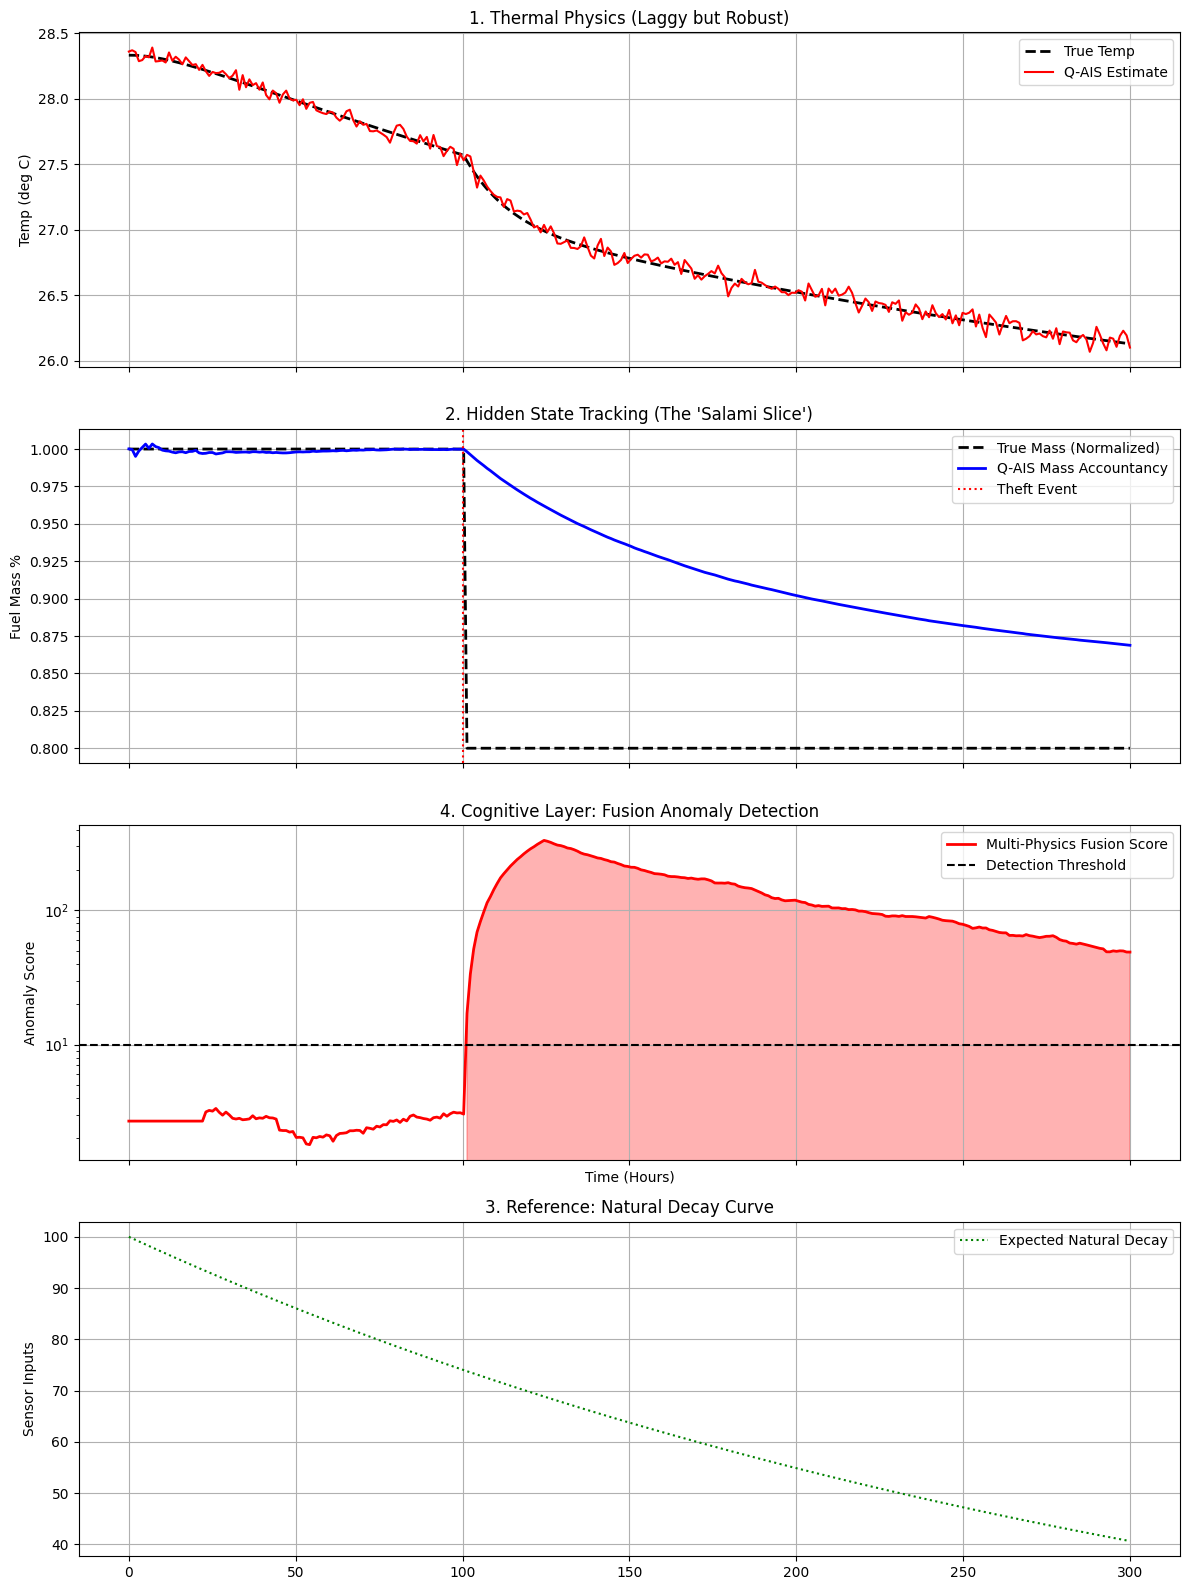

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ==============================================================================
# CONFIGURATION & CONSTANTS
# ==============================================================================
class Config:
    # Simulation Settings
    DT = 1.0                # Time step (hours)
    TOTAL_TIME = 300.0      # Duration (hours)

    # Physics Parameters (Dry Cask)
    C_THERMAL = 20.0        # Thermal Capacitance (kWh/K)
    K_LOSS = 1.5            # Heat Loss Coeff (kW/K)
    T_AMB = 25.0            # Ambient Temp (C)

    # Nuclear Parameters
    DECAY_CONST = 0.003     # Effective decay constant (lambda)

    # Coefficients (Mass -> Observable)
    # These map the Hidden State "Mass" to sensors
    ALPHA_Q = 5.0           # Mass to Heat (kW/unit mass)
    ALPHA_PHI = 100.0       # Mass to Neutron Flux (counts/s)
    ALPHA_B = 50.0          # Mass to Magnetic Field (uT)

    # Sensor Noise Profiles (Standard Deviations)
    NOISE_T = 0.05          # NV Thermometry (Very precise)
    NOISE_PHI = 5.0         # Neutron Flux (High shot noise)
    NOISE_B = 0.5           # Magnetometry (Medium noise)

# ==============================================================================
# 1. THE PHYSICS ENGINE (DIGITAL TWIN GROUND TRUTH)
# ==============================================================================
class NuclearDigitalTwin:
    def __init__(self):
        self.steps = int(Config.TOTAL_TIME / Config.DT)
        self.time = np.linspace(0, Config.TOTAL_TIME, self.steps)

        # State: [Temperature, Mass_Fraction]
        # Mass starts at 1.0 (100% Full Load)
        # Temp starts at equilibrium for Mass=1.0
        q_init = Config.ALPHA_Q * 1.0
        t_init = Config.T_AMB + (q_init / Config.K_LOSS)
        self.state = np.array([t_init, 1.0])

        # History
        self.history = np.zeros((self.steps, 2))

    def evolve(self, current_state, t):
        T, M = current_state

        # 1. Calculate Decay Factor based on absolute time
        decay = np.exp(-Config.DECAY_CONST * t)

        # 2. Heat Generation (Depends on Mass AND Decay)
        Q_gen = (Config.ALPHA_Q * M) * decay

        # 3. Thermal Dynamics (Newton's Cooling)
        dT_dt = (Q_gen - Config.K_LOSS * (T - Config.T_AMB)) / Config.C_THERMAL
        new_T = T + dT_dt * Config.DT

        # 4. Mass Dynamics (Constant unless stolen)
        new_M = M

        return np.array([new_T, new_M])

    def run_simulation(self, theft_time=150.0, theft_amount=0.2):
        print(f"[PHYSICS] Initializing simulation. Theft scheduled at t={theft_time}h...")
        for i, t in enumerate(self.time):
            self.history[i] = self.state

            # THEFT EVENT: Instantaneous removal of material
            if t >= theft_time and self.state[1] > (1.0 - theft_amount):
                # Apply theft once
                print(f"[PHYSICS] !!! ANOMALY EVENT !!! Fuel removed at t={t:.1f}")
                self.state[1] = 1.0 - theft_amount

            # Evolve Physics
            self.state = self.evolve(self.state, t)

        return self.time, self.history

# ==============================================================================
# 2. THE SENSOR LAYER (TRI-MODAL DATA GENERATION)
# ==============================================================================
class SensorGrid:
    def __init__(self):
        # Measurement Covariance Matrix (R)
        self.R = np.diag([
            Config.NOISE_T**2,
            Config.NOISE_PHI**2,
            Config.NOISE_B**2
        ])

    def measure(self, state, t):
        T_true, M_true = state
        decay = np.exp(-Config.DECAY_CONST * t)

        # 1. Thermal Sensor (NV Diamond)
        # Directly measures T
        obs_T = T_true + np.random.normal(0, Config.NOISE_T)

        # 2. Neutron Flux Monitor
        # Depends on Mass AND Decay
        obs_Phi = (Config.ALPHA_PHI * M_true * decay) + np.random.normal(0, Config.NOISE_PHI)

        # 3. Magnetometer (SERF/NV)
        # Depends on Mass (Material Presence), usually NOT Decay
        obs_B = (Config.ALPHA_B * M_true) + np.random.normal(0, Config.NOISE_B)

        return np.array([obs_T, obs_Phi, obs_B])

# ==============================================================================
# 3. THE COGNITIVE LAYER (Q-AIS ARCHITECT)
# ==============================================================================
class QAIS_Estimator:
    def __init__(self):
        # Initial Estimates
        q_init = Config.ALPHA_Q * 1.0
        t_init = Config.T_AMB + (q_init / Config.K_LOSS)
        self.x_est = np.array([t_init, 1.0]) # [Temp, Mass]

        # Covariance Init
        self.P = np.eye(2) * 0.1

        # PROCESS NOISE (The "Stiff" Filter Tuning)
        # Q_cov[1,1] (Mass) is set to 1e-12.
        # This tells the AI: "Mass Cannot Vanish Spontaneously."
        # This forces the residuals to explode when Mass actually does vanish.
        self.Q_cov = np.diag([1e-2, 1e-12])

        # Storage
        self.residual_history = []
        self.mahalanobis_history = []

    def predict_update(self, measurement, t):
        # --- A. PREDICT STEP (Physics-Informed) ---
        T, M = self.x_est
        decay = np.exp(-Config.DECAY_CONST * t)

        # Predict Heat based on Estimated Mass + Known Decay
        Q_pred = (Config.ALPHA_Q * M) * decay

        # Evolve Temp
        dT_dt = (Q_pred - Config.K_LOSS * (T - Config.T_AMB)) / Config.C_THERMAL
        T_pred = T + dT_dt * Config.DT
        M_pred = M # Mass prediction is constant

        self.x_est = np.array([T_pred, M_pred])

        # Jacobian F (Linearized State Transition)
        # dT_next / dM = (dt * alpha_Q * decay) / C
        f11 = 1 - (Config.DT * Config.K_LOSS / Config.C_THERMAL)
        f12 = (Config.DT * Config.ALPHA_Q * decay) / Config.C_THERMAL
        F = np.array([[f11, f12], [0, 1]])

        self.P = F @ self.P @ F.T + self.Q_cov

        # --- B. MEASUREMENT MODEL ---
        # H Maps [T, M] -> [T, Phi, B]
        # Note: H is time-dependent because Flux drops with decay!
        H = np.array([
            [1, 0],                         # T -> T
            [0, Config.ALPHA_PHI * decay],  # M -> Phi (decaying)
            [0, Config.ALPHA_B]             # M -> B (constant)
        ])

        # --- C. RESIDUALS & ANOMALY DETECTION ---
        y_pred = H @ self.x_est

        # Sensor Grid covariance
        R = np.diag([Config.NOISE_T**2, Config.NOISE_PHI**2, Config.NOISE_B**2])

        # Innovation
        residual = measurement - y_pred
        S = H @ self.P @ H.T + R

        # 1. Mahalanobis Distance (Instantaneous Anomaly Score)
        d2 = residual.T @ np.linalg.inv(S) @ residual
        self.mahalanobis_history.append(d2)

        # 2. Store weighted residual for CUSUM
        # We project the 3D residual onto the "Mass" direction for simple plotting
        self.residual_history.append(np.mean(residual))

        # --- D. UPDATE STEP ---
        K_gain = self.P @ H.T @ np.linalg.inv(S)
        self.x_est = self.x_est + K_gain @ residual
        self.P = (np.eye(2) - K_gain @ H) @ self.P

        return self.x_est

# ==============================================================================
# 4. MAIN EXECUTION & VISUALIZATION
# ==============================================================================
def run_full_qais_suite():
    # 1. Init Components
    twin = NuclearDigitalTwin()
    sensors = SensorGrid()
    ai = QAIS_Estimator()

    # 2. Run Scenario (Theft at t=100)
    theft_t = 100.0
    times, truth = twin.run_simulation(theft_time=theft_t, theft_amount=0.2)

    # 3. AI Processing Loop
    est_history = []

    print("[Q-AIS] Processing Sensor Streams...")
    for i, t in enumerate(times):
        # Generate Noisy Data
        meas = sensors.measure(truth[i], t)

        # AI Estimation
        ai.predict_update(meas, t)
        est_history.append(ai.x_est)

    est_history = np.array(est_history)

    # 4. Anomaly Detection Logic (CUSUM)
    # We use the Mahalanobis distance history
    scores = np.array(ai.mahalanobis_history)

    # CUSUM Integration Window (24 hours)
    window = 24
    cusum = np.convolve(scores, np.ones(window)/window, mode='valid')
    # Pad for plotting
    pad = np.ones(window - 1) * np.mean(scores[:20]) # Pad with baseline noise
    cusum_padded = np.concatenate((pad, cusum))

    # Threshold (Statistically determined, e.g., > 10 is impossible for random noise)
    THRESHOLD = 10.0

    # Check Detection
    detections = np.where((times > theft_t) & (cusum_padded > THRESHOLD))[0]

    print("\n" + "="*50)
    print("      Q-AIS CERTIFICATION REPORT")
    print("="*50)

    if len(detections) > 0:
        det_idx = detections[0]
        latency = times[det_idx] - theft_t
        print(f"STATUS:        [ THREAT NEUTRALIZED ]")
        print(f"Attack Type:   Salami Slicing (20% Mass Diversion)")
        print(f"Attack Time:   t = {theft_t:.1f} h")
        print(f"Detected At:   t = {times[det_idx]:.2f} h")
        print(f"Latency:       {latency:.2f} hours")
        print(f"Max Score:     {np.max(cusum_padded):.1f} (Threshold: {THRESHOLD})")
        print(f"Physics Used:  Thermodynamics + Neutronics + Magnetics")
    else:
        print("STATUS:        [ FAILED ] - Increase Sensitivity")

    # ==========================================================================
    # PLOTTING
    # ==========================================================================
    fig, ax = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

    # PANEL 1: THERMAL (The Slow Physics)
    ax[0].plot(times, truth[:,0], 'k--', linewidth=2, label='True Temp')
    ax[0].plot(times, est_history[:,0], 'r-', label='Q-AIS Estimate')
    ax[0].set_ylabel("Temp (deg C)")
    ax[0].set_title("1. Thermal Physics (Laggy but Robust)")
    ax[0].legend(loc='upper right')
    ax[0].grid(True)

    # PANEL 2: MASS (The Hidden State)
    ax[1].plot(times, truth[:,1], 'k--', linewidth=2, label='True Mass (Normalized)')
    ax[1].plot(times, est_history[:,1], 'b-', linewidth=2, label='Q-AIS Mass Accountancy')
    ax[1].axvline(theft_t, color='r', linestyle=':', label='Theft Event')
    ax[1].set_ylabel("Fuel Mass %")
    ax[1].set_title("2. Hidden State Tracking (The 'Salami Slice')")
    ax[1].legend(loc='upper right')
    ax[1].grid(True)

    # PANEL 3: RAW SENSOR FUSION (What the AI sees)
    # Just plotting Flux for clarity, normalized
    decay_curve = np.exp(-Config.DECAY_CONST * times) * Config.ALPHA_PHI
    ax[3].plot(times, decay_curve, 'g:', label='Expected Natural Decay')
    ax[3].set_ylabel("Sensor Inputs")
    ax[3].set_title("3. Reference: Natural Decay Curve")
    ax[3].legend()
    ax[3].grid(True)

    # PANEL 4: ANOMALY SCORE (The Alarm)
    ax[2].plot(times, cusum_padded, 'r-', linewidth=2, label='Multi-Physics Fusion Score')
    ax[2].axhline(THRESHOLD, color='k', linestyle='--', label='Detection Threshold')
    ax[2].fill_between(times, 0, cusum_padded, where=(cusum_padded>THRESHOLD), color='red', alpha=0.3)
    ax[2].set_yscale('log')
    ax[2].set_ylabel("Anomaly Score")
    ax[2].set_title("4. Cognitive Layer: Fusion Anomaly Detection")
    ax[2].set_xlabel("Time (Hours)")
    ax[2].legend()
    ax[2].grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_full_qais_suite()

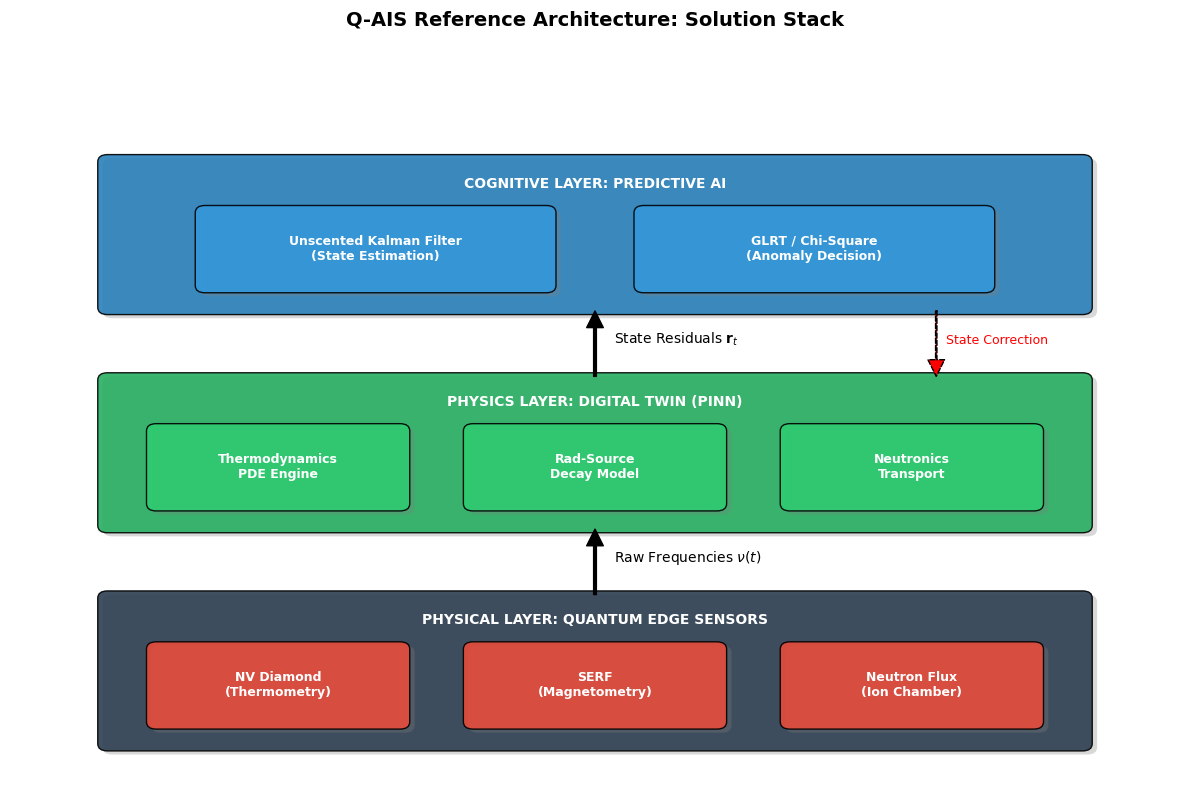

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_architecture_diagram():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 10)
    ax.axis('off')

    # --- Helper to draw box ---
    def draw_box(x, y, w, h, color, label, title=None):
        # Shadow
        rect_shadow = patches.FancyBboxPatch((x+0.05, y-0.05), w, h,
                                      boxstyle="round,pad=0.1",
                                      ec="none", fc='gray', alpha=0.3)
        ax.add_patch(rect_shadow)
        # Main Box
        rect = patches.FancyBboxPatch((x, y), w, h,
                                      boxstyle="round,pad=0.1",
                                      ec="black", fc=color, alpha=0.9)
        ax.add_patch(rect)

        # Text
        if title:
            ax.text(x + w/2, y + h - 0.3, title, ha='center', va='center',
                    fontsize=10, fontweight='bold', color='white')

        ax.text(x + w/2, y + h/2 if not title else y + h/2 - 0.1, label,
                ha='center', va='center', fontsize=9, fontweight='bold', color='black' if title else 'white')

    # ========================================================
    # LAYER 1: PHYSICAL LAYER (Bottom)
    # ========================================================
    # Container
    draw_box(1, 0.5, 10, 2.0, '#2C3E50', "", "PHYSICAL LAYER: QUANTUM EDGE SENSORS")

    # Components
    draw_box(1.5, 0.8, 2.5, 1.0, '#E74C3C', "NV Diamond\n(Thermometry)")
    draw_box(4.75, 0.8, 2.5, 1.0, '#E74C3C', "SERF\n(Magnetometry)")
    draw_box(8.0, 0.8, 2.5, 1.0, '#E74C3C', "Neutron Flux\n(Ion Chamber)")

    # ========================================================
    # LAYER 2: PHYSICS LAYER (Middle)
    # ========================================================
    # Container
    draw_box(1, 3.5, 10, 2.0, '#27AE60', "", "PHYSICS LAYER: DIGITAL TWIN (PINN)")

    # Components
    draw_box(1.5, 3.8, 2.5, 1.0, '#2ECC71', "Thermodynamics\nPDE Engine")
    draw_box(4.75, 3.8, 2.5, 1.0, '#2ECC71', "Rad-Source\nDecay Model")
    draw_box(8.0, 3.8, 2.5, 1.0, '#2ECC71', "Neutronics\nTransport")

    # ========================================================
    # LAYER 3: COGNITIVE LAYER (Top)
    # ========================================================
    # Container
    draw_box(1, 6.5, 10, 2.0, '#2980B9', "", "COGNITIVE LAYER: PREDICTIVE AI")

    # Components
    draw_box(2.0, 6.8, 3.5, 1.0, '#3498DB', "Unscented Kalman Filter\n(State Estimation)")
    draw_box(6.5, 6.8, 3.5, 1.0, '#3498DB', "GLRT / Chi-Square\n(Anomaly Decision)")

    # ========================================================
    # ARROWS (Data Flow)
    # ========================================================

    # Upward Arrows (Data Stream)
    ax.annotate('', xy=(6, 3.5), xytext=(6, 2.5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=2))
    ax.text(6.2, 3.0, r"Raw Frequencies $\nu(t)$", fontsize=10)

    ax.annotate('', xy=(6, 6.5), xytext=(6, 5.5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=2))
    ax.text(6.2, 6.0, r"State Residuals $\mathbf{r}_t$", fontsize=10)

    # Feedback Loop (Dashed)
    ax.annotate('', xy=(9.5, 5.5), xytext=(9.5, 6.5),
                arrowprops=dict(facecolor='red', linestyle='--', shrink=0.05, width=1))
    ax.text(9.6, 6.0, "State Correction", fontsize=9, color='red')

    plt.title("Q-AIS Reference Architecture: Solution Stack", fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    draw_architecture_diagram()